> #####  A. 개요
- 배경: 학습 데이터 기반, 개인화 된 구독 유형 추천 → 만족도 개선
- 목표: 구독 유형(subscription_type) 추천하는 모델 구현



> ##### B.데이터 준비/1.라이브러리 임포트

In [1]:
'''B.데이터 준비/1.라이브러리 임포트'''
# 데이터 핸들링
import numpy as np
import pandas as pd


# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder


# 모델 학습
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold


# 모델 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.metrics import classification_report

> ##### B.데이터 준비/2.csv 로드

In [2]:
'''B.데이터 준비/2.csv 로드'''


# Google Drive 파일 로드를 위한 Google Drive 마운트
from google.colab import drive

drive.mount('/content/drive')


# csv 파일 읽기
def r_csv(*file_names):
    path = '/content/drive/MyDrive/Colab Notebooks/data/'
    data_list = []
    for file_name in file_names:
        data = pd.read_csv(path + file_name, encoding='EUC-KR')
        data_list.append(data)
    return data_list

# csv 파일 읽기
origin_train_data, origin_test_data, origin_sample_submission = r_csv('train.csv', 'test.csv', 'sample_submission.csv')

# 원본 보존을 위해 카피해서 사용
train_data, test_data, sample_submission = origin_train_data.copy(), origin_test_data.copy(), origin_sample_submission.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ##### C.EDA/1.로드 파일 확인


| No.   | type      | isna?   | column                            | description                       | memo                                      | count  | uni    | min       | max        | mean      | std      |
| :---: | :-------: | :-----: | --------------------------------- | --------------------------------- | ----------------------------------------- | :----- | :----- | :---      | :---       | :----     | :---     |
| 1     | object    | F       | user_id                           | 사용자 고유 식별자                        |                                           | 10000  | 10000  | -         | -          | -         | -        |
| 2     | int64     | F       | subscription_duration             | 사용자 서비스에 가입후 경과 기간                |                                           | 10000  | 23     | 1         | 23         | 11.8974   | 6.600896 |
| 3     | int64     | F       | recent_login_time                 | 사용자가 마지막으로 로그인한 시간                | (일)                                       | 10000  | 29     | 1         | 29         | 15.0132   | 8.362573 |
| 4     | float64   | F       | average_login_time                | 사용자의 일반적인 로그인 시간                  | (평균으로 추정)                                 | 10000  | 10000  | 2.366189  | 26.99849   | 14.994076 | 3.001869 |
| 5     | float64   | F       | average_time_per_learning_session | 각 학습 세션에 소요된 평균 시간                | (분)                                       | 10000  | 10000  | 0.011515  | 503.372616 | 54.91772  | 56.02431 |
| 6     | int64     | F       | monthly_active_learning_days      | 월간 활동적인 학습 일수                     | (활동적인 기준 을 알 수 없음)                        | 10000  | 24     | 1         | 24         | 12.5454   | 6.932239 |
| 7     | int64     | F       | total_completed_courses           | 완료한 총 코스 수                        |                                           | 10000  | 27     | 1         | 27         | 12.2275   | 3.634125 |
| 8     | float64   | F       | recent_learning_achievement       | 최근 학습 성취도                         | (퍼센트가 아닐 수 있음 100 넘은 것)                   | 10000  | 10000  | 35.941755 | 112.643828 | 75.029513 | 9.968529 |
| 9     | int64     | F       | abandoned_learning_sessions       | 중단된 학습 세션 수                       | (세션 이탈 횟수 추정)                             | 10000  | 13     | 0         | 12         | 3.0436    | 1.755052 |
| 10    | int64     | F       | community_engagement_level        | 커뮤니티 참여도                          |                                           | 10000  | 5      | 1         | 5          | 3.8861    | 1.262175 |
| 11    | object    | F       | preferred_difficulty_level        | 선호하는 난이도                          | low, Medium, High                         | 10000  | 3      | -         | -          | -         | -        |
| 12    | object    | F       | **subscription_type**                 | **구독 유형**                             | basic, premium                            | 10000  | 2      | -         | -          | -         | -        |
| 13    | int64     | F       | customer_inquiry_history          | 고객 문의 이력                          |                                           | 10000  | 10     | 0         | 10         | 2.0105    | 1.420983 |
| 14    | int64     | F       | payment_pattern                   | 구독 패턴 (3개월간)                      | 0: 안함(0) , 안함 (0) , 안함 (0)  (2진수)         | 10000  | 8      | 0         | 7          | 3.5029    | 2.311261 |
| 15    | int64     | F       | target                            | 다음달 구독 취소 여부                      | 0: 안함, 1: 함  (test_data는 없음)              | 10000  | 2      | 0         | 1          | 0.6199    | 0.485435 |

    - 열 확인
      - 15개(float64(3), int64(9), object(3))
      - 활동적인 학습수와 코스. 성취도, 소요시간, 일수 상관성 예상
    - 행 확인
      - 결측 X
      - 이상('average_time_per_learning_session', 'achievement' 가능성)

In [3]:
'''C.EDA/1.로드 파일 확인'''

# 함수 선언-가독성을 위한 엔터

def enter():

    for _ in range(3):

        print()


def check(*args):
    enter()
    for i, data in enumerate(args):
        data_name = f"data_{i+1}"
        print(f'[ {data_name} ]')
        enter()
        display(data.info())
        enter()
        display(data.isna().any())
        enter()
        display(data.nunique())
        enter()
        display(data.head())
        enter()
        display(data.describe())
        enter()

# csv 데이터 확인
check(train_data, test_data, sample_submission)




[ data_1 ]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  100

None

user_id                              False
subscription_duration                False
recent_login_time                    False
average_login_time                   False
average_time_per_learning_session    False
monthly_active_learning_days         False
total_completed_courses              False
recent_learning_achievement          False
abandoned_learning_sessions          False
community_engagement_level           False
preferred_difficulty_level           False
subscription_type                    False
customer_inquiry_history             False
payment_pattern                      False
target                               False
dtype: bool

user_id                              10000
subscription_duration                   23
recent_login_time                       29
average_login_time                   10000
average_time_per_learning_session    10000
monthly_active_learning_days            24
total_completed_courses                 27
recent_learning_achievement          10000
abandoned_learning_sessions             13
community_engagement_level               5
preferred_difficulty_level               3
subscription_type                        2
customer_inquiry_history                10
payment_pattern                          8
target                                   2
dtype: int64

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,customer_inquiry_history,payment_pattern,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.897400,15.013200,14.994076,54.917720,12.545400,12.227500,75.029513,3.043600,3.886100,2.010500,3.502900,0.619900
std,6.600896,8.362573,3.001869,56.024310,6.932239,3.634125,9.968529,1.755052,1.262175,1.420983,2.311261,0.485435
min,1.000000,1.000000,2.366189,0.011515,1.000000,1.000000,35.941755,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,8.000000,13.025597,15.276611,7.000000,10.000000,68.278054,2.000000,3.000000,1.000000,1.000000,0.000000
50%,12.000000,15.000000,14.979228,37.578818,13.000000,12.000000,75.126061,3.000000,4.000000,2.000000,4.000000,1.000000
75%,18.000000,22.000000,16.995340,75.584200,19.000000,15.000000,81.718976,4.000000,5.000000,3.000000,6.000000,1.000000
max,23.000000,29.000000,26.998490,503.372616,24.000000,27.000000,112.643828,12.000000,5.000000,10.000000,7.000000,1.000000





[ data_2 ]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  100

None

user_id                              False
subscription_duration                False
recent_login_time                    False
average_login_time                   False
average_time_per_learning_session    False
monthly_active_learning_days         False
total_completed_courses              False
recent_learning_achievement          False
abandoned_learning_sessions          False
community_engagement_level           False
preferred_difficulty_level           False
subscription_type                    False
customer_inquiry_history             False
payment_pattern                      False
dtype: bool

user_id                              10000
subscription_duration                   23
recent_login_time                       29
average_login_time                   10000
average_time_per_learning_session    10000
monthly_active_learning_days            24
total_completed_courses                 27
recent_learning_achievement          10000
abandoned_learning_sessions             12
community_engagement_level               5
preferred_difficulty_level               3
subscription_type                        2
customer_inquiry_history                11
payment_pattern                          8
dtype: int64

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern
0,0001d6e9,9,15,11.173051,7.047243,19,15,82.074557,3,5,Low,Premium,2,7
1,0002c77d,11,8,13.448592,24.583327,10,16,80.546040,4,2,Low,Basic,4,4
2,0002df5b,11,28,18.548201,1.707616,9,19,73.676957,5,5,Low,Premium,1,3
3,000b6068,14,17,13.383311,21.391389,12,6,63.314635,0,4,High,Premium,1,5
4,00184a0c,19,6,11.919663,18.126987,8,15,55.899647,1,4,Medium,Basic,1,3


,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,customer_inquiry_history,payment_pattern
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,12.055700,14.998000,15.026034,55.481839,12.454600,12.197800,75.029148,2.990700,3.905400,2.008100,3.498100
std,6.587635,8.364341,2.984562,56.901447,6.926567,3.647246,10.060532,1.724155,1.273504,1.406923,2.284364
min,1.000000,1.000000,4.304375,0.002851,1.000000,1.000000,39.224932,0.000000,1.000000,0.000000,0.000000
25%,6.000000,8.000000,13.023887,15.796562,6.000000,10.000000,68.297270,2.000000,3.000000,1.000000,2.000000
50%,12.000000,15.000000,15.031312,37.801621,12.000000,12.000000,74.942627,3.000000,4.000000,2.000000,3.000000
75%,18.000000,22.000000,17.051425,75.911356,19.000000,15.000000,81.853699,4.000000,5.000000,3.000000,5.000000
max,23.000000,29.000000,25.707977,606.510444,24.000000,28.000000,117.858556,11.000000,5.000000,10.000000,7.000000





[ data_3 ]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10000 non-null  object
 1   target   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


None

user_id    False
target     False
dtype: bool

user_id    10000
target         1
dtype: int64

,user_id,target
0,0001d6e9,0
1,0002c77d,0
2,0002df5b,0
3,000b6068,0
4,00184a0c,0


,target
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


> ##### C.EDA/2.상관성 확인(범주형 제외한, 전체 컬럼)
- 구독 유형이 범주형이라 알 수 없음 인코딩 필요
![이미지](https://i.imgur.com/W5m8zgm.png)

<ipython-input-4-3e8f551bc4bf>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train_data.corr()


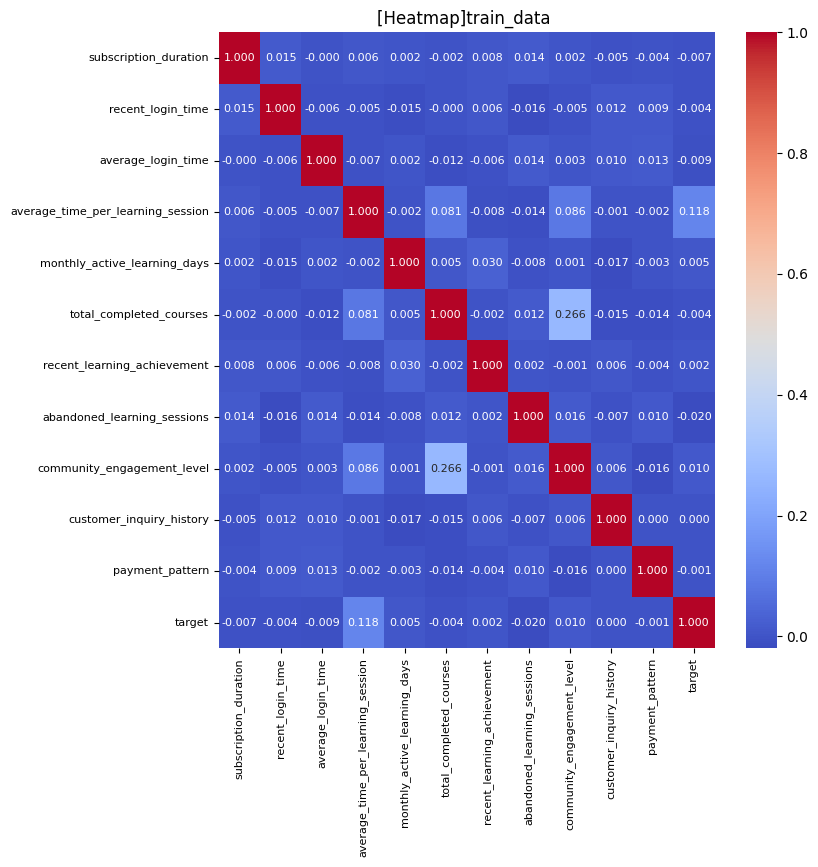

In [4]:
'''C.EDA/2.상관성 확인(범주형 제외한, 전체 컬럼)'''


# train_data를 DataFrame으로 변환
df_train_data = pd.DataFrame(train_data)


# 컬럼 간 상관관계 행렬 계산
correlation_matrix = df_train_data.corr()


# 히트맵 시각화
plt.figure(figsize=(8, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', annot_kws={'size': 8})

plt.title('[Heatmap]train_data ')


# 전체 레이블 크기 조절
plt.tick_params(axis='both', which='both', labelsize=8)


# 특정 레이블 크기 조절

plt.show()

> ##### C.EDA/3.상관성 확인(범주형 인코딩, 전체 컬럼)
-
![이미지](https://i.imgur.com/UWHzUMN.png)


- 특정 열에 상관성이 집중 되는 것으로 보임
  - 'subscription_type'
  - 'total_completed_courses'

- 이상치 예상 되는 아래 컬럼, 상관성이 크게 없어 보임
	- 'average_time_per_learning_session'
	- 'recent_learning_achievement'


범주형 변수('user_id'제외): ['preferred_difficulty_level', 'subscription_type']
수치형 변수: ['subscription_duration', 'recent_login_time', 'average_login_time', 'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'recent_learning_achievement', 'abandoned_learning_sessions', 'community_engagement_level', 'customer_inquiry_history', 'payment_pattern']
[train_data | 스케일링 전]


,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ae6b76bc,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,24588752,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,e4622a54,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,e07fbad9,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1


[train_data | 스케일링 후]


,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,0.167046,-0.121165,-0.015962,-0.829869,0.786885,1.038128,-0.669045,-0.024844,0.090246,Low,Basic,1.400157,0.647774,0
1,a0a60abb,0.621553,0.357181,1.152389,0.316456,0.498363,0.212579,2.261009,-0.594656,-0.702077,Medium,Basic,-0.711163,1.080460,1
2,b9f171ae,1.530566,-1.675788,0.400155,-0.591616,0.065581,0.487762,1.939124,-0.024844,0.090246,Medium,Premium,-1.414937,1.513146,1
3,5dc0ba8b,-1.650980,0.476767,0.877690,-0.218820,0.931145,1.588495,-0.489192,-1.734280,-0.702077,Low,Basic,-0.711163,-1.515656,1
4,65c83654,-1.196473,-1.197443,2.130972,-0.431503,0.931145,-0.612970,0.691049,-0.594656,0.090246,Medium,Basic,0.696384,-1.515656,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ae6b76bc,1.530566,1.672631,-0.088767,0.520083,0.786885,1.038128,-1.009498,-0.594656,0.882568,Low,Premium,-0.711163,-1.082970,1
9996,24588752,-0.287460,-0.479924,1.459157,-0.168737,-0.511462,-1.163337,0.774549,-0.024844,-0.702077,Medium,Basic,-0.007390,1.513146,1
9997,e4622a54,-0.741967,1.433458,1.081681,1.292087,1.652449,0.487762,0.655930,-0.024844,0.882568,High,Basic,-0.711163,1.080460,1
9998,e07fbad9,-0.135958,-0.958270,1.262518,-0.885740,-0.367201,-0.612970,1.490379,0.544968,0.882568,Low,Basic,-0.007390,-1.515656,1


[train_data | 인코딩 후]


,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,0.167046,-0.121165,-0.015962,-0.829869,0.786885,1.038128,-0.669045,-0.024844,0.090246,0,0,1.400157,0.647774,0
1,a0a60abb,0.621553,0.357181,1.152389,0.316456,0.498363,0.212579,2.261009,-0.594656,-0.702077,1,0,-0.711163,1.080460,1
2,b9f171ae,1.530566,-1.675788,0.400155,-0.591616,0.065581,0.487762,1.939124,-0.024844,0.090246,1,1,-1.414937,1.513146,1
3,5dc0ba8b,-1.650980,0.476767,0.877690,-0.218820,0.931145,1.588495,-0.489192,-1.734280,-0.702077,0,0,-0.711163,-1.515656,1
4,65c83654,-1.196473,-1.197443,2.130972,-0.431503,0.931145,-0.612970,0.691049,-0.594656,0.090246,1,0,0.696384,-1.515656,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ae6b76bc,1.530566,1.672631,-0.088767,0.520083,0.786885,1.038128,-1.009498,-0.594656,0.882568,0,1,-0.711163,-1.082970,1
9996,24588752,-0.287460,-0.479924,1.459157,-0.168737,-0.511462,-1.163337,0.774549,-0.024844,-0.702077,1,0,-0.007390,1.513146,1
9997,e4622a54,-0.741967,1.433458,1.081681,1.292087,1.652449,0.487762,0.655930,-0.024844,0.882568,2,0,-0.711163,1.080460,1
9998,e07fbad9,-0.135958,-0.958270,1.262518,-0.885740,-0.367201,-0.612970,1.490379,0.544968,0.882568,0,0,-0.007390,-1.515656,1


<ipython-input-5-2d47e97418af>:62: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train_data.corr()


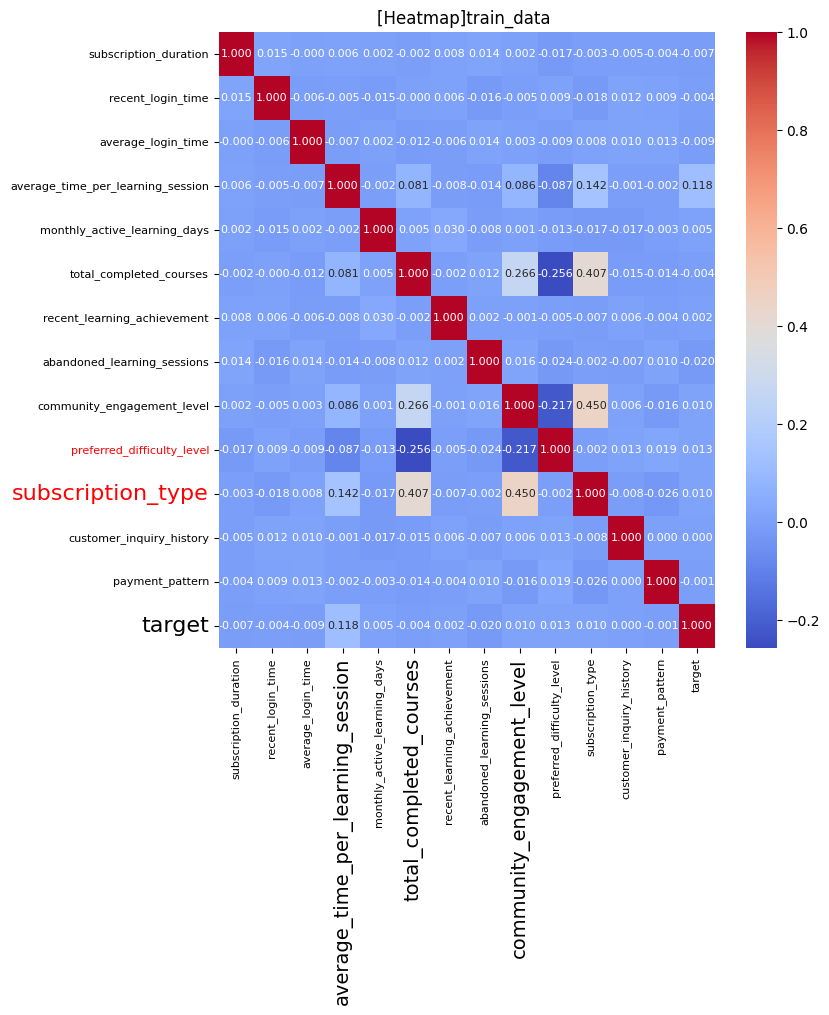

In [5]:
'''2.데이터 탐색하기/상관관계 탐색 1/시각화 (전체 컬럼)'''


# 범주형 변수 구분
categorical_cols = []

for col in train_data.columns:

    if train_data[col].dtype == 'object' and col not in ['user_id']:

        categorical_cols.append(col)


# 수치형 변수 구분
numerical_cols = []

for col in train_data.columns:

    if train_data[col].dtype in ['int64', 'float64'] and col not in ['target']:

        numerical_cols.append(col)


# 범주형, 수치형 확인 & 출력

print("범주형 변수('user_id'제외):", (categorical_cols))

print('수치형 변수:', (numerical_cols))

print("[train_data | 스케일링 전]")

display(train_data)


# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()


# 수치형 데이터에 대해 스케일링 적용
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

print("[train_data | 스케일링 후]")

display(train_data)


# train_data, 범주형 데이터 인코딩
train_data['preferred_difficulty_level'] = train_data['preferred_difficulty_level'].map({'Low':0, 'Medium':1,'High':2})

train_data['subscription_type'] = train_data['subscription_type'].map({'Basic':0, 'Premium':1})

print("[train_data | 인코딩 후]")

display(train_data)


# train_data를 DataFrame으로 변환
df_train_data = pd.DataFrame(train_data)


# 컬럼 간 상관관계 행렬 계산
correlation_matrix = df_train_data.corr()


# 히트맵 시각화
plt.figure(figsize=(8, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', annot_kws={'size': 8})

plt.title('[Heatmap]train_data ')


# 전체 레이블 크기 조절
plt.tick_params(axis='both', which='both', labelsize=8)


# 특정 레이블 크기 조절
plt.gca().get_xticklabels()[3].set_fontsize(14)  # x축 레이블 중 04번 레이블 폰트 크기 14

plt.gca().get_xticklabels()[5].set_fontsize(14)  # x축 레이블 중 06번 레이블 폰트 크기 14

plt.gca().get_xticklabels()[8].set_fontsize(14)  # x축 레이블 중 08번 레이블 폰트 크기 14

plt.gca().get_yticklabels()[10].set_fontsize(16)  # y축 레이블 중 10번 레이블 폰트 크기 16

plt.gca().get_yticklabels()[13].set_fontsize(16)  # y축 레이블 중 13번 레이블 폰트 크기 16


# 특정 레이블 색상 변경
plt.gca().get_yticklabels()[9].set_color('red')  # y축 레이블 중 12번 레이블 폰트 색상을 빨간색으로 변경

plt.gca().get_yticklabels()[10].set_color('red')  # y축 레이블 중 13번 레이블 폰트 색상을 빨간색으로 변경

plt.show()

> ##### C.EDA/4.상관성 확인(구독 유형 기준, 전체 컬럼)
- 'subscription_type' 기준으로 시각화
![이미지](https://i.imgur.com/BHElHPW.png)


차이를 보이는 열 체크
  - community_engagement_level
  - 'total_completed_courses'
  - abandoned_learning_sessions
  - customer inquiry_history
  - 'average_time_per_learning_session' (이상치 우려)
  - 'recent_learning_achievement' (이상치 우려)

In [6]:
# '''C.EDA/3.상관성 확인(구독 유형 기준, 전체 컬럼)'''


# # 데이터 초기화
# train_data = origin_train_data.copy()


# # 인코딩
# train_data['preferred_difficulty_level'] = train_data['preferred_difficulty_level'].map({'Low':0, 'Medium':1,'High':2})

# train_data['subscription_type'] = train_data['subscription_type'].map({'Basic':0, 'Premium':1})


# # 바이올린 플롯
# plt.figure(figsize=(9,16))
# i = 0
# for col in train_data.columns:
#     i += 1
#     plt.subplot(5,3,i)
#     sns.violinplot(data=train_data, x='subscription_type',y=col)
#     plt.title(f"{col}")
# plt.tight_layout()

> ##### C.EDA/3.상관성 확인 **결과**
    - (범주형 제외한, 전체 컬럼) 컬럼간 상관성 낮아보임, 범주형 인코딩 확인 필요
    - (범주형 인코딩, 전체 컬럼) 구독 유형과 상관성 보이는 일부 컬럼 확인
    - (구독 유형 기준, 전체 컬럼) 변별성 예상 되는 열 확인


구별될 수 있는 차이가 있을 것으로 예상되는 열 체크
```
  - community_engagement_level
  - 'total_completed_courses'
  - abandoned_learning_sessions
  - customer inquiry_history (프리미엄 허들로 인한, 선후 관계중 후 관계라고 판단)
  - 'average_time_per_learning_session' (이상치 우려)
  - 'recent_learning_achievement' (이상치 우려)
```


> ##### K-NN 모델로 모델링 진행
- 수치 기반 데이터 분류 작업에서 성능 우수
- 단순하고 효율적


  1. 데이터 기반으로 학습 유형을 추천하는 모델
    - 분류로 접근해야하는 주제라고 판단
    - 사람의 취향에 발생하는 데이터로, 일정 패턴으로 구분될 것이라고 판단


  2. 데이터 양이 많지 않음
    - 행이 10,000개 정도, 데이터가 많지 않음
    - 15개의 열 중, 3개의 열을 제외한 나머지가 수치형 열
  

  3. 데이터 특성상 적합할 것이라는 판단
    - 구독 유형이 2개로 적음, 늘어날 가능성은 있지만, 많이 생기기는 어려울 것
    - 수치 이상치를 보이는 열 적고, 그마저도 드랍가능

> ##### D.모델링/1.데이터 초기회 & 전처리

- 불필요 컬럼 삭제:
- 수치형 데이터:  StandardScaler 스케일링
- 범주형 인코딩: Low == 0, Medium == 1, High == 2, Basic == 0, Premium == 1

In [7]:
'''3.모델링/1.데이터 초기화 & 전처리'''


# 데이터 초기화
train_data = origin_train_data.copy()

test_data = origin_test_data.copy()

sample_submission = origin_sample_submission.copy()


# 학습, 테스트 데이터 초기화 확인 출력
enter()
print('학습, 테스트 데이터 초기화')
print('train_data')
enter()
display(train_data)
enter()
print('test_data')
enter()
display(test_data)


# 범주형 변수 구분
categorical_cols = []

for col in train_data.columns:

    if train_data[col].dtype == 'object' and col not in ['user_id']:

        categorical_cols.append(col)

# 수치형 변수 구분
numerical_cols = []

for col in train_data.columns:

    if train_data[col].dtype in ['int64', 'float64'] and col not in ['target']:

        numerical_cols.append(col)


print("범주형 변수('user_id'제외):", (categorical_cols))
enter()
print('수치형 변수:', (numerical_cols))


# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()


# 수치형 데이터에 대해 스케일링 적용
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])



# 불필요한 컬럼 삭제
train_data.drop(['user_id', 'customer_inquiry_history','average_time_per_learning_session','recent_learning_achievement'], axis=1, inplace=True)

test_data.drop(['user_id','customer_inquiry_history','average_time_per_learning_session','recent_learning_achievement'], axis=1, inplace=True)


# 불필요 컬럼 삭제 출력
enter()
print('불필요 컬럼 삭제')
print('train_data')
enter()
display(train_data)
enter()
print('test_data')
enter()
display(test_data)






# 수치형 데이터 스케일링 적용 출력
enter()
print('수치형 데이터 스케일링 적용')
print('train_data')
enter()
display(train_data)
enter()
print('test_data')
enter()
display(test_data)

# 단계별로 인코딩 test_data
train_data['preferred_difficulty_level'] = train_data['preferred_difficulty_level'].map({'Low':0, 'Medium':1,'High':2})

test_data['preferred_difficulty_level'] = test_data['preferred_difficulty_level'].map({'Low':0, 'Medium':1,'High':2})


#일반은 0, 프리미엄은 1로 인코딩
train_data['subscription_type'] = train_data['subscription_type'].map({'Basic':0, 'Premium':1})

test_data['subscription_type'] = test_data['subscription_type'].map({'Basic':0, 'Premium':1})


# 인코딩 결과 출력
enter()
print(' 인코딩: Low == 0, Medium == 1, High == 2')
print(' 인코딩: Basic == 0, Premium == 1')

print('train_data')
enter()
display(train_data)
enter()
print('test_data')
enter()
display(test_data)




학습, 테스트 데이터 초기화
train_data





,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ae6b76bc,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,24588752,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,e4622a54,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,e07fbad9,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1





test_data





,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern
0,0001d6e9,9,15,11.173051,7.047243,19,15,82.074557,3,5,Low,Premium,2,7
1,0002c77d,11,8,13.448592,24.583327,10,16,80.546040,4,2,Low,Basic,4,4
2,0002df5b,11,28,18.548201,1.707616,9,19,73.676957,5,5,Low,Premium,1,3
3,000b6068,14,17,13.383311,21.391389,12,6,63.314635,0,4,High,Premium,1,5
4,00184a0c,19,6,11.919663,18.126987,8,15,55.899647,1,4,Medium,Basic,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ffe2eba5,10,24,11.924481,90.251023,20,21,70.552157,4,5,Medium,Premium,1,6
9996,ffe710f1,15,26,12.395364,10.205804,18,7,67.558845,2,2,Medium,Basic,3,5
9997,ffeccdef,6,13,17.036811,20.346781,22,9,89.294007,5,2,Medium,Basic,1,0
9998,fff3fcea,18,9,15.758179,156.521711,13,10,82.218390,2,5,Low,Premium,2,5


범주형 변수('user_id'제외): ['preferred_difficulty_level', 'subscription_type']



수치형 변수: ['subscription_duration', 'recent_login_time', 'average_login_time', 'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'recent_learning_achievement', 'abandoned_learning_sessions', 'community_engagement_level', 'customer_inquiry_history', 'payment_pattern']



불필요 컬럼 삭제
train_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern,target
0,0.167046,-0.121165,-0.015962,0.786885,1.038128,-0.024844,0.090246,Low,Basic,0.647774,0
1,0.621553,0.357181,1.152389,0.498363,0.212579,-0.594656,-0.702077,Medium,Basic,1.080460,1
2,1.530566,-1.675788,0.400155,0.065581,0.487762,-0.024844,0.090246,Medium,Premium,1.513146,1
3,-1.650980,0.476767,0.877690,0.931145,1.588495,-1.734280,-0.702077,Low,Basic,-1.515656,1
4,-1.196473,-1.197443,2.130972,0.931145,-0.612970,-0.594656,0.090246,Medium,Basic,-1.515656,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.530566,1.672631,-0.088767,0.786885,1.038128,-0.594656,0.882568,Low,Premium,-1.082970,1
9996,-0.287460,-0.479924,1.459157,-0.511462,-1.163337,-0.024844,-0.702077,Medium,Basic,1.513146,1
9997,-0.741967,1.433458,1.081681,1.652449,0.487762,-0.024844,0.882568,High,Basic,1.080460,1
9998,-0.135958,-0.958270,1.262518,-0.367201,-0.612970,0.544968,0.882568,Low,Basic,-1.515656,1





test_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
0,-0.438962,-0.001579,-1.272946,0.931145,0.762945,-0.024844,0.882568,Low,Premium,1.513146
1,-0.135958,-0.838683,-0.514866,-0.367201,1.038128,0.544968,-1.494400,Low,Basic,0.215088
2,-0.135958,1.553045,1.184030,-0.511462,1.863678,1.114781,0.882568,Low,Premium,-0.217598
3,0.318548,0.237594,-0.536614,-0.078680,-1.713703,-1.734280,0.090246,High,Premium,0.647774
4,1.076059,-1.077856,-1.024218,-0.655723,0.762945,-1.164468,0.090246,Medium,Basic,-0.217598
...,...,...,...,...,...,...,...,...,...,...
9995,-0.287460,1.074699,-1.022613,1.075406,2.414044,0.544968,0.882568,Medium,Premium,1.080460
9996,0.470051,1.313872,-0.865742,0.786885,-1.438520,-0.594656,-1.494400,Medium,Basic,0.647774
9997,-0.893469,-0.240751,0.680522,1.363928,-0.888154,1.114781,-1.494400,Medium,Basic,-1.515656
9998,0.924557,-0.719097,0.254555,0.065581,-0.612970,-0.594656,0.882568,Low,Premium,0.647774





수치형 데이터 스케일링 적용
train_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern,target
0,0.167046,-0.121165,-0.015962,0.786885,1.038128,-0.024844,0.090246,Low,Basic,0.647774,0
1,0.621553,0.357181,1.152389,0.498363,0.212579,-0.594656,-0.702077,Medium,Basic,1.080460,1
2,1.530566,-1.675788,0.400155,0.065581,0.487762,-0.024844,0.090246,Medium,Premium,1.513146,1
3,-1.650980,0.476767,0.877690,0.931145,1.588495,-1.734280,-0.702077,Low,Basic,-1.515656,1
4,-1.196473,-1.197443,2.130972,0.931145,-0.612970,-0.594656,0.090246,Medium,Basic,-1.515656,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.530566,1.672631,-0.088767,0.786885,1.038128,-0.594656,0.882568,Low,Premium,-1.082970,1
9996,-0.287460,-0.479924,1.459157,-0.511462,-1.163337,-0.024844,-0.702077,Medium,Basic,1.513146,1
9997,-0.741967,1.433458,1.081681,1.652449,0.487762,-0.024844,0.882568,High,Basic,1.080460,1
9998,-0.135958,-0.958270,1.262518,-0.367201,-0.612970,0.544968,0.882568,Low,Basic,-1.515656,1





test_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
0,-0.438962,-0.001579,-1.272946,0.931145,0.762945,-0.024844,0.882568,Low,Premium,1.513146
1,-0.135958,-0.838683,-0.514866,-0.367201,1.038128,0.544968,-1.494400,Low,Basic,0.215088
2,-0.135958,1.553045,1.184030,-0.511462,1.863678,1.114781,0.882568,Low,Premium,-0.217598
3,0.318548,0.237594,-0.536614,-0.078680,-1.713703,-1.734280,0.090246,High,Premium,0.647774
4,1.076059,-1.077856,-1.024218,-0.655723,0.762945,-1.164468,0.090246,Medium,Basic,-0.217598
...,...,...,...,...,...,...,...,...,...,...
9995,-0.287460,1.074699,-1.022613,1.075406,2.414044,0.544968,0.882568,Medium,Premium,1.080460
9996,0.470051,1.313872,-0.865742,0.786885,-1.438520,-0.594656,-1.494400,Medium,Basic,0.647774
9997,-0.893469,-0.240751,0.680522,1.363928,-0.888154,1.114781,-1.494400,Medium,Basic,-1.515656
9998,0.924557,-0.719097,0.254555,0.065581,-0.612970,-0.594656,0.882568,Low,Premium,0.647774





 인코딩: Low == 0, Medium == 1, High == 2
 인코딩: Basic == 0, Premium == 1
train_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern,target
0,0.167046,-0.121165,-0.015962,0.786885,1.038128,-0.024844,0.090246,0,0,0.647774,0
1,0.621553,0.357181,1.152389,0.498363,0.212579,-0.594656,-0.702077,1,0,1.080460,1
2,1.530566,-1.675788,0.400155,0.065581,0.487762,-0.024844,0.090246,1,1,1.513146,1
3,-1.650980,0.476767,0.877690,0.931145,1.588495,-1.734280,-0.702077,0,0,-1.515656,1
4,-1.196473,-1.197443,2.130972,0.931145,-0.612970,-0.594656,0.090246,1,0,-1.515656,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.530566,1.672631,-0.088767,0.786885,1.038128,-0.594656,0.882568,0,1,-1.082970,1
9996,-0.287460,-0.479924,1.459157,-0.511462,-1.163337,-0.024844,-0.702077,1,0,1.513146,1
9997,-0.741967,1.433458,1.081681,1.652449,0.487762,-0.024844,0.882568,2,0,1.080460,1
9998,-0.135958,-0.958270,1.262518,-0.367201,-0.612970,0.544968,0.882568,0,0,-1.515656,1





test_data





,subscription_duration,recent_login_time,average_login_time,monthly_active_learning_days,total_completed_courses,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
0,-0.438962,-0.001579,-1.272946,0.931145,0.762945,-0.024844,0.882568,0,1,1.513146
1,-0.135958,-0.838683,-0.514866,-0.367201,1.038128,0.544968,-1.494400,0,0,0.215088
2,-0.135958,1.553045,1.184030,-0.511462,1.863678,1.114781,0.882568,0,1,-0.217598
3,0.318548,0.237594,-0.536614,-0.078680,-1.713703,-1.734280,0.090246,2,1,0.647774
4,1.076059,-1.077856,-1.024218,-0.655723,0.762945,-1.164468,0.090246,1,0,-0.217598
...,...,...,...,...,...,...,...,...,...,...
9995,-0.287460,1.074699,-1.022613,1.075406,2.414044,0.544968,0.882568,1,1,1.080460
9996,0.470051,1.313872,-0.865742,0.786885,-1.438520,-0.594656,-1.494400,1,0,0.647774
9997,-0.893469,-0.240751,0.680522,1.363928,-0.888154,1.114781,-1.494400,1,0,-1.515656
9998,0.924557,-0.719097,0.254555,0.065581,-0.612970,-0.594656,0.882568,0,1,0.647774


> ##### D.모델링/2.KNN model 적용

In [8]:
'''3.모델링/2.KNN model 적용'''

# X, y 할당하기
X = train_data.drop(['subscription_type'], axis=1) # X = 구독 유형만 제외

y = train_data['subscription_type'] # y = 구독 유형만 선택

test_data = test_data.drop(['subscription_type'], axis=1) # 구독 유형만 제외


# 할당 데이터 확인
print(X.shape)

print(y.shape)

print(test_data.shape) # target 열이 없어서 12?

y.value_counts() # values 값 이진분류


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)


# KNN 모델 생성
knn = KNeighborsClassifier(n_neighbors=5)


# 모델 학습
knn.fit(X_train, y_train)


# 테스트 데이터로 예측
y_pred = knn.predict(X_test)

(10000, 10)
(10000,)
(10000, 9)


> ##### D.모델링/3.모델평가

- 정확도 출력
- 오차 행렬 출력

정확도: 0.722
오차행렬:
[[895 296]
 [260 549]]


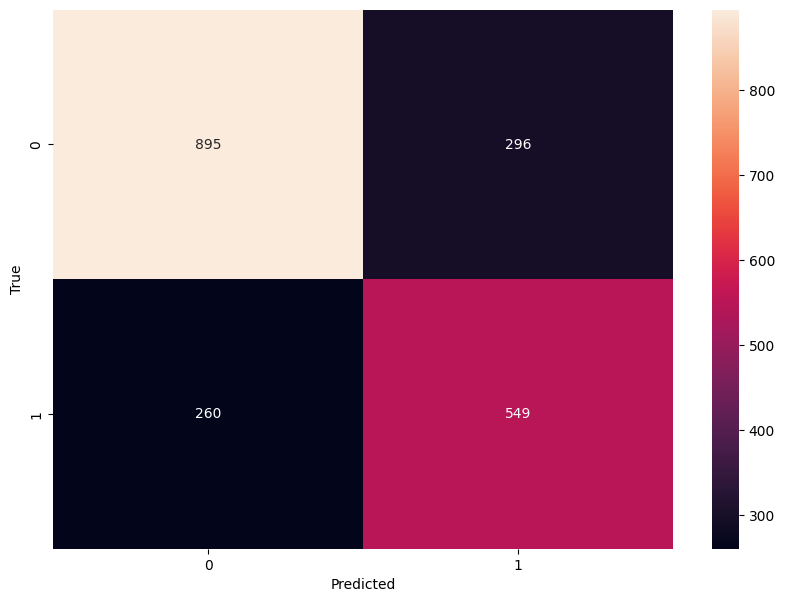

In [9]:
'''D.모델링/3.모델 평가'''


# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("정확도:", accuracy)


# 오차행렬 출력
confusion_mat = confusion_matrix(y_test, y_pred)
print("오차행렬:")
print(confusion_mat)


# 오차행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

> ##### E.저장/1.모델평가

In [10]:
'''E.저장/1.모델평가'''
# 저장코드 작성

'E.저장/1.모델평가'